# 빅데이터 분석 특강 (중간고사 해설) 4월 27일 

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Special Topics in Big Data Analysis]

**원하는 방향**
- 손실함수와 로그우도함수, LSE와 MLE $\to$ 1번
- 효율적으로 학습률을 찾는 방법 $\to$ 2번
- 미니배치의 개념 + 확률적 경사하강법 $\to$ 2번 + 다른 문제들
- 복잡한 모형과 오버피팅 $\to$ 3번의 (1)
- 분석결과를 물어보는 방법 $\to$ 4번

### imports 

In [1]:
import numpy as np
import tensorflow as tf 
import tensorflow.experimental.numpy as tnp 

In [2]:
tnp.experimental_enable_numpy_behavior()

In [3]:
import matplotlib.pyplot as plt 

### `1`. 경사하강법과 tf.GradientTape()의 사용방법 (30점)

**손실함수와 로그우도함수, LSE와 MLE**

`(1)` 아래는 $X_i \overset{iid}{\sim} N(3,2^2)$ 를 생성하는 코드이다. 

In [5]:
tf.random.set_seed(43052)
x= tnp.random.randn(10000)*2+3
x

<tf.Tensor: shape=(10000,), dtype=float64, numpy=
array([ 4.12539849,  5.46696729,  5.27243374, ...,  2.89712332,
        5.01072291, -1.13050477])>

함수 $L(\mu,\sigma)$을 최대화하는 $(\mu,\sigma)$를 `tf.GradeintTape()`를 활용하여 추정하라. (경사하강법 혹은 경사상승법을 사용하고 $\mu$의 초기값은 2로 $\sigma$의 초기값은 3으로 설정할 것) 

$$L(\mu,\sigma)=\prod_{i=1}^{n}f(x_i), \quad f(x_i)=\frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{1}{2}(\frac{x_i-\mu}{\sigma})^2}$$

**(풀이)**

In [6]:
sigma = tf.Variable(3.0) 
mu = tf.Variable(2.0)

상수는 안 곱해도 결과는 같을테니 빼도 상관없겠지

In [7]:
with tf.GradientTape() as tape: 
    pdf = 1/sigma * tnp.exp(-0.5*((x-mu)/sigma)**2)
    logL = tf.reduce_sum(tnp.log(pdf) ) 
tape.gradient(logL,[mu,sigma]) 

[<tf.Tensor: shape=(), dtype=float32, numpy=1129.3353>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1488.3431>]

경사하강법에서 `assign_sub` 가장 작은 값을 구하는

경사상승법에서 `assign_add` 가장 큰 값을 구하는

In [8]:
for i in range(1000):
    with tf.GradientTape() as tape: 
        pdf = 1/sigma * tnp.exp(-0.5*((x-mu)/sigma)**2)
        logL = tf.reduce_sum(tnp.log(pdf) ) 
    slope1, slope2 = tape.gradient(logL,[mu,sigma]) 
    mu.assign_add(slope1* 0.1/10000) # N=10000 
    sigma.assign_add(slope2* 0.1/10000) 

```python
for i in range(1000):
    with tf.GradientTape() as tape: 
        pdf = 1/sigma * tnp.exp(-0.5*((x-mu)/sigma)**2)
        logL = -tf.reduce_sum(tnp.log(pdf) ) 
    slope1, slope2 = tape.gradient(logL,[mu,sigma]) 
    mu.assign_add(slope1* 0.1/10000) # N=10000 
    sigma.assign_sub(slope2* 0.1/10000) 
```

In [9]:
mu,sigma

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0163972>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.9870595>)

`(2)` 아래는 $X_i \overset{iid}{\sim} Ber(0.8)$을 생성하는 코드이다. 

In [10]:
tf.random.set_seed(43052)
x= tf.constant(np.random.binomial(1,0.8,(10000,)))
x

<tf.Tensor: shape=(10000,), dtype=int64, numpy=array([0, 1, 1, ..., 1, 1, 1])>

함수 $L(p)$을 최대화하는 $p$를 `tf.GradeintTape()`를 활용하여 추정하라. (경사하강법 혹은 경사상승법을 사용하고 $p$의 초기값은 0.3으로 설정할 것) 


$$L(\mu,\sigma)=\prod_{i=1}^{n}f(x_i), \quad f(x_i)=p^{x_i}(1-p)^{1-x_i}$$

**(풀이)**

In [11]:
p=tf.Variable(0.3) 
for i in range(1000):
    with tf.GradientTape() as tape: 
        pdf = p**x * (1-p)**(1-x) 
        logL = tf.reduce_sum(tnp.log(pdf)) 
    slope = tape.gradient(logL,p) 
    p.assign_add(slope* 0.1/10000) # N=10000 

In [12]:
p

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.7984>

`(3)` 아래의 모형에 따라서 $\{Y_i\}_{i=1}^{10000}$를 생성하는 코드를 작성하라. 
- $Y_i \overset{iid}{\sim} N(\mu_i,1)$ 
- $\mu_i = \beta_0 + \beta_1 x_i = 0.5 + 2 x_i$ , where $x_i = \frac{i}{10000}$

함수 $L(\beta_0,\beta_1)$을 최대화하는 $(\beta_0,\beta_1)$를 `tf.GradeintTape()`를 활용하여 추정하라. (경사하강법 혹은 경사상승법을 사용하고 $\beta_0,\beta_1$의 초기값은 모두 1로 설정할 것) 

$$L(\beta_0,\beta_1)=\prod_{i=1}^{n}f(y_i), \quad f(y_i)=\frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}(y_i-\mu_i)^2}, \quad \mu_i=\beta_0+\beta_1 x_i$$

**(풀이)**

In [ ]:
x= tf.constant(np.arange(1,10001)/10000)
y= tnp.random.randn(10000) + (0.5 + 2*x) 

In [ ]:
beta0= tf.Variable(1.0)
beta1= tf.Variable(1.0) 
for i in range(2000):
    with tf.GradientTape() as tape: 
        mu = beta0 + beta1*x 
        pdf = tnp.exp(-0.5*(y-mu)**2)
        logL = tf.reduce_sum(tnp.log(pdf)) 
    slope1, slope2 = tape.gradient(logL,[beta0,beta1]) 
    beta0.assign_add(slope1* 0.1/10000) # N=10000 
    beta1.assign_add(slope2* 0.1/10000) 

In [ ]:
beta0, beta1

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5553082>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.8987025>)

### `2`. 회귀분석의 이론적해와 tf.keras.optimizer 이용방법 (20점)

**효율적으로 학습률을 찾는 방법**

**미니배치의 개념 + 확률적 경사하강법**

아래와 같은 선형모형을 고려하자. 

$$y_i = \beta_0 + \beta_1 x_i +\epsilon_i.$$

이때 오차항은 정규분포로 가정한다. 즉 $\epsilon_i \overset{iid}{\sim} N(0,\sigma^2)$라고 가정한다. 

관측데이터가 아래와 같을때 아래의 물음에 답하라. 

In [ ]:
#x= tnp.array([20.1, 22.2, 22.7, 23.3, 24.4, 25.1, 26.2, 27.3, 28.4, 30.4])

X= tnp.array([[1.0, 20.1], [1.0, 22.2], [1.0, 22.7], [1.0, 23.3], [1.0, 24.4],
              [1.0, 25.1], [1.0, 26.2], [1.0, 27.3], [1.0, 28.4], [1.0, 30.4]])
y= tnp.array([55.4183651 , 58.19427589, 61.23082496, 62.31255873, 63.1070028 , 
              63.69569103, 67.24704918, 71.43650092, 73.10130336, 77.84988286]).reshape(10,1)

`(1)` MSE loss를 최소화 하는 $\beta_0,\beta_1$의 해석해를 구하라. 

**(풀이)**

In [ ]:
tf.linalg.inv(X.T @ X ) @ X.T @ y

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[9.94457323],
       [2.21570461]])>

`(2)` 경사하강법과 MSE loss의 도함수를 이용하여 $\beta_0,\beta_1$을 추정하라. 

**주의** tf.GradeintTape()를 이용하지 말고 MSE loss의 해석적 도함수를 사용할 것.

**(풀이)**

In [ ]:
beta= tnp.array([5,10]).reshape(2,1) 

In [ ]:
for i in range(50000): 
    beta = beta - 0.0015 * (-2*X.T @y + 2*X.T@X@beta)/10 

In [ ]:
beta

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[9.28579424],
       [2.24168098]])>

`(3)` `tf.keras.optimizers`의 `apply_gradients()`를 이용하여 $\beta_0,\beta_1$을 추정하라. 

**(풀이)**

In [ ]:
beta = tf.Variable(tnp.array([5.0,10.0]).reshape(2,1)) 
opt = tf.optimizers.SGD(0.0015) 
for i in range(50000): 
    with tf.GradientTape() as tape: 
        loss = (y-X@beta).T @ (y-X@beta) / 10 
    slope = tape.gradient(loss,beta) 
    opt.apply_gradients([(slope,beta)]) 

In [ ]:
beta

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[9.28579425],
       [2.24168098]])>

`(4)` `tf.keras.optimizers`의 `minimize()`를 이용하여 $\beta_0,\beta_1$을 추정하라. 

**(풀이)**

In [ ]:
beta = tf.Variable(tnp.array([5.0,10.0]).reshape(2,1)) 
opt = tf.optimizers.SGD(0.0015) 
loss_fn = lambda: (y-X@beta).T @ (y-X@beta) / 10 
for i in range(50000): 
    opt.minimize(loss_fn,beta)  

In [ ]:
beta

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[9.28579425],
       [2.24168098]])>

### `3`. keras를 이용한 풀이 (30점)

`(1)` 아래와 같은 모형을 고려하자. 

$$y_i= \beta_0 + \sum_{k=1}^{5} \beta_k \cos(k t_i)+\epsilon_i, \quad i=0,1,\dots, 999$$

여기에서 $t_i=\frac{2\pi i}{1000}$ 이다. 그리고 $\epsilon_i \sim i.i.d~ N(0,\sigma^2)$, 즉 서로 독립인 표준정규분포에서 추출된 샘플이다. 위의 모형에서 아래와 같은 데이터를 관측했다고 가정하자. 

**복잡한 모형과 오버피팅**

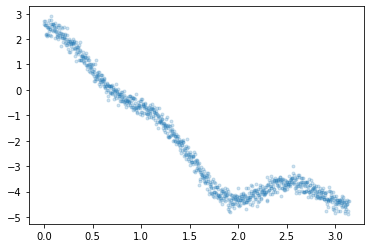

In [ ]:
np.random.seed(43052)
t= np.array(range(1000))* np.pi/1000
y = -2+ 3*np.cos(t) + 1*np.cos(2*t) + 0.5*np.cos(5*t) + np.random.randn(1000)*0.2
plt.plot(t,y,'.',alpha=0.2)

tf.keras를 이용하여 $\beta_0,\dots,\beta_5$를 추정하라. ($\beta_0,\dots,\beta_5$의 참값은 각각 -2,3,1,0,0,0.5 이다) 

**(풀이)**

In [ ]:
y = y.reshape(1000,1)
x1 = np.cos(t) 
x2 = np.cos(2*t)
x3 = np.cos(3*t)
x4 = np.cos(4*t)
x5 = np.cos(5*t)
X = tf.stack([x1,x2,x3,x4,x5],axis=1)

In [ ]:
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1)) 
net.compile(loss='mse',optimizer='sgd') 
net.fit(X,y,batch_size=1000, epochs = 1000, verbose=0) 

In [ ]:
net.weights

[<tf.Variable 'dense/kernel:0' shape=(5, 1) dtype=float32, numpy=
 array([[ 3.0008891e+00],
        [ 1.0066563e+00],
        [ 1.8562324e-03],
        [-3.8704993e-03],
        [ 4.9712175e-01]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([-2.0122595], dtype=float32)>]

`(2)` 아래와 같은 모형을 고려하자. 

$$y_i \sim Ber(\pi_i), ~ \text{where} ~ \pi_i=\frac{\exp(w_0+w_1x_i)}{1+\exp(w_0+w_1x_i)}$$


위의 모형에서 관측한 데이터는 아래와 같다. 

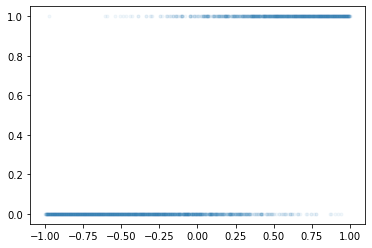

In [ ]:
tf.random.set_seed(43052)
x = tnp.linspace(-1,1,2000) 
y = tf.constant(np.random.binomial(1, tf.nn.sigmoid(-1+5*x)),dtype=tf.float64) 
plt.plot(x,y,'.',alpha=0.05)

tf.keras를 이용하여 $w_0,w_1$을 추정하라. (참고: $w_0, w_1$에 대한 참값은 -1과 5이다.) 

**(풀이)**

In [ ]:
x= x.reshape(2000,1) 
y= y.reshape(2000,1) 

In [ ]:
net= tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
net.compile(optimizer='sgd', loss= tf.losses.binary_crossentropy) 
net.fit(x,y,epochs=10000,batch_size=2000, verbose=0)

In [ ]:
net.weights

[<tf.Variable 'dense_2/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[4.201613]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32, numpy=array([-0.90172565], dtype=float32)>]

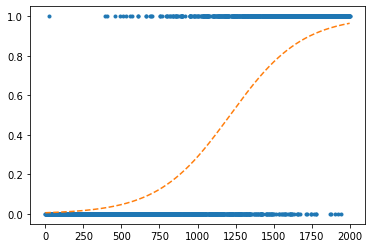

In [ ]:
plt.plot(y,'.')
plt.plot(net(x),'--')

### `4`. Piecewise-linear regression (15점) 

**분석결과를 물어보는 방법**

아래의 모형을 고려하자. 

model: $y_i=\begin{cases} x_i +0.3\epsilon_i & x\leq 0 \\ 3.5x_i +0.3\epsilon_i & x>0 \end{cases}$ 

아래는 위의 모형에서 생성한 샘플이다. 

In [ ]:
## data 
np.random.seed(43052)
N=100
x= np.linspace(-1,1,N).reshape(N,1)
y= np.array(list(map(lambda x: x*1+np.random.normal()*0.3 if x<0 else x*3.5+np.random.normal()*0.3,x))).reshape(N,1)

`(1)` 다음은 $(x_i,y_i)$를 아래와 같은 아키텍처로 적합시키는 코드이다. 

- $\hat{y} =  \hat{\beta}_0+\hat{\beta}_1x $

In [ ]:
tf.random.set_seed(43054) 
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1)) 
net.compile(optimizer=tf.optimizers.SGD(0.1),loss='mse')
net.fit(x,y,batch_size=N,epochs=1000,verbose=0) # numpy로 해도 돌아감

케라스에 의해 추정된 $\hat{\beta}_0,\hat{\beta}_1$을 구하라. 

In [ ]:
net.weights

[<tf.Variable 'dense_6/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[2.2616348]], dtype=float32)>,
 <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32, numpy=array([0.6069048], dtype=float32)>]

**(풀이)**

- $\hat{\beta}_0= 0.6069048$
- $\hat{\beta}_1= 2.2616348$

`(2)` 다음은 $(x_i,y_i)$를 아래와 같은 아키텍처로 적합시키는 코드이다. 

- $\boldsymbol{u}= x\boldsymbol{W}^{(1)}+\boldsymbol{b}^{(1)}$
- $\boldsymbol{v}= \text{relu}(u)$ 
- $yhat= \boldsymbol{v}\boldsymbol{W}^{(2)}+b^{(2)}$

In [ ]:
tf.random.set_seed(43056) 
## 1단계
net = tf.keras.Sequential() 
net.add(tf.keras.layers.Dense(2))
net.add(tf.keras.layers.Activation('relu')) 
net.add(tf.keras.layers.Dense(1))
net.compile(optimizer=tf.optimizers.SGD(0.1),loss='mse')
net.fit(x,y,epochs=1000,verbose=0,batch_size=N)

${\boldsymbol u}$를 이용하여 ${\boldsymbol v}$를 만드는 코드와 ${\boldsymbol v}$를 이용하여 $yhat$를 만드는 코드를 작성하라. 

**(풀이)**

In [ ]:
u=net.layers[0](x)
v=net.layers[1](u) 
yhat=net.layers[2](v) 

`(3)` 아래는 `(1)-(2)`번 모형에 대한 discussion이다. 올바른 것을 모두 골라라. 

**(곤이)** (2) 모형은 활성화함수로 relu를 사용하였다. 

**(철용)** (1) 모형에서 추정해야할 파라메터의 수는 2개이다. 

**(아귀)** (2) 모형이 (1) 모형보다 복잡한 모형이다. 

~~**(짝귀)** (1) 의 모형은 오버피팅의 위험이 있다.~~

### `5`. 다음을 잘 읽고 참과 거짓을 판단하라. (5점)

`(1)` 적절한 학습률이 선택된다면, 경사하강법은 손실함수가 convex일때 언제나 전역최소해를 찾을 수 있다.

~~`(2)` `tf.GradeintTape()`는 경사하강법을 이용하여 최적점을 찾아주는 tool이다.~~

`(3)` 학습률이 크다는 것은 파라메터는 1회 업데이트 하는 양이 크다는 것을 의미한다. 

~~`(4)` 학습률이 크면 학습파라메터의 수렴속도가 빨라지지만 때때로 과적합에 빠질 수도 있다.~~

`(5)` 단순회귀분석에서 MSE loss를 최소화 하는 해는 경사하강법을 이용하지 않아도 해석적으로 구할 수 있다. 